In [27]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
from os import getenv
import pandas as pd
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader, random_split, Subset, RandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, Resize, CenterCrop, Grayscale, ToTensor, RandAugment, RandomResizedCrop, ColorJitter
from MODEL_CONFIG import model_config

load_dotenv()


config = {
    "DATA_DIR_PATH": getenv("DATA_DIR_PATH"),
    "SAVE_TORCH_DIR_PATH": getenv("SAVE_TORCH_DIR_PATH"),
    "DATA_FILE_DIR": getenv("DATA_FILE_DIR")
}



In [28]:
# image/structure specific

data_config = {
"folder": "ClassId",
"filename": "FileName",
"label_col_name": model_config["LABEL_COL_NAME"],
"data_dir": config["DATA_DIR_PATH"],
"data_label_filepath": config["DATA_FILE_DIR"],
"data_label_filename": model_config["DATA_LABEL_FILENAME"],
"learning_rate": model_config["LEARNING_RATE"],
"batch_size": model_config["BATCH_SIZE"],
"epochs": model_config["EPOCHS"],
"saved_model_filename":model_config["SAVED_MODEL_FILENAME"]
}

### Define Custom Image Dataset

In [29]:
class CustomImageDataset(Dataset):
    def __init__(self, data_config, transform=None, target_transform=None):
        # self.img_labels = read_xml(data_label_filepath, xpath="//Data//Image")
        self.data_dir = data_config["data_dir"]
        # self.img_labels = pd.read_csv(data_config["data_label_filepath"] + data_config["data_label_filename"])
        self.data = pd.read_csv(data_config["data_label_filepath"] + data_config["data_label_filename"])
        # self.one_hot = data_config["encoded_label_dict"]
        self.transform = transform
        self.target_transform = target_transform
        self.encoded_labels = self.encode_labels()
        self.decoded_labels = self.decode_labels()


    def __len__(self):
        # return len(self.img_labels)
        return len(self.data)

    def __getitem__(self, idx):
        # This logic works with images in a file structure
        # image_path = self.data_dir + "/" + str(self.img_labels["ClassId"].iloc[idx])+ "/" + self.img_labels["FileName"].iloc[idx]
        
        # base_dir = data_config["data_dir"]
        # folder = str(self.img_labels[data_config.get("folder")].iloc[idx])
        # file = self.img_labels[data_config.get("filename")].iloc[idx]
        # path_bundle = set(base_dir, folder, file)
        base_dir = data_config["data_dir"]
        folder = str(self.data[data_config.get("folder")].iloc[idx])
        file = self.data[data_config.get("filename")].iloc[idx]
        path_bundle = set([base_dir, folder, file])
        
        if None in path_bundle:
            print("Error getting image path. Check path bundle.")
        else:
            image_path =  base_dir + "/" + folder + "/" + file
            image = Image.open(image_path, mode = "r")
            # image = image_path
            data_df = pd.DataFrame(self.data)
            unencoded_label = data_df[data_config["label_col_name"]].iloc[idx]
            label = self.encoded_labels.get(unencoded_label)
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)
        return image, label
        
    def encode_labels(self):
        """
        Creates one-hot enocded labels given a list of labels.
        Input: 
            [list] or pd.Series
        Output:
            {encoded label dict}; ; {"label": 0}
        """
        data_df = pd.DataFrame(self.data)
        label_series = data_df[data_config["label_col_name"]]
        one_hot_encoded_labels = {value : count for count, value in enumerate(label_series.unique())}
        return one_hot_encoded_labels



    def decode_labels(self):
        """
        Decodes labels
        Input:
            {encoded label dict}; {"label": 0}
        Output:
            {decoded labels}; {"0": "label"}
        """

        decoded_labels = {str(val) : key for key, val in self.encoded_labels.items()}
        return decoded_labels
        
    

### Define Model

In [30]:
class NeuralNetwork(nn.Module):
    def __init__(self, desired_image_size, full_dataset):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(desired_image_size * desired_image_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, len(full_dataset.encoded_labels))
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

### Define transformations

In [31]:
# TRANSFORMATIONS
# train_transform = Compose([Grayscale(num_output_channels=1),Resize(224), CenterCrop(224), ToTensor()]) 
desired_image_size = 224
train_transform = Compose([Grayscale(num_output_channels=1), RandAugment(num_ops=4), CenterCrop(150), Resize(desired_image_size), ToTensor()]) 
target_transform = int


### Define Train/test loops

In [32]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Define test predictor

In [33]:
# function to visualize results
def test_predictor(trained_model, val_img, val_label, decoded_labels):

  # predict
  with torch.no_grad():
    prediction = trained_model(val_img)
    pred_label = np.argmax(prediction)

  # output
  plt.imshow(val_img.squeeze())
  plt.show()
  actual_label = str(val_label.item())
  predicted_label = str(pred_label.item())
  print(f"Actual label: {decoded_labels.get(actual_label)}")
  print(f"Predicted label: {decoded_labels.get(predicted_label)}")

### Instantiate Dataset and split

In [34]:

# DEFINE dataset using custom class in order to try and incorporate label data
full_dataset = CustomImageDataset(data_config, train_transform, target_transform)

#SPLIT INTO TEST AND TRAIN SUBSETS

print('This is the length of the full data set:', len(full_dataset))
# untouched_set_size = int(len(full_dataset) * 0.70)
# train_set_size = int(len(full_dataset) * 0.2)
# test_set_size = int(len(full_dataset) * 0.05)
# validation_set_size = int(len(full_dataset))-train_set_size-test_set_size-untouched_set_size

# train_set, test_set, validation_set, untouched_set = random_split(full_dataset, [train_set_size, test_set_size, validation_set_size, untouched_set_size])

train_set_size = int(len(full_dataset) * 0.8)
test_set_size = int(len(full_dataset) * 0.1)
validation_set_size = int(len(full_dataset))-train_set_size-test_set_size
train_set, test_set, validation_set = random_split(full_dataset, [train_set_size, test_set_size, validation_set_size])

# print(train_set)
# print(test_set)
# print(validation_set)
   
# After
print('='*30)
print('Train data set:', len(train_set))
print('Test data set:', len(test_set))
print('Val data set:', len(validation_set))
print('='*30)

#get subsets of each set
# train_sampler = RandomSampler(data_source=train_set, num_samples=5000)
# test_sampler = RandomSampler(data_source=test_set, num_samples=500)
# validation_sampler = RandomSampler(data_source=validation_set, num_samples=500)

# loading dataset in data loader
#dataloader = DataLoader(dataset=training_data, batch_size=4, shuffle=True)
batch_size = data_config["batch_size"]
train_dataloader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle = True)
test_dataloader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle = True)

features, label_names = next(iter(train_dataloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {label_names.size()}")

This is the length of the full data set: 1951
Train data set: 1560
Test data set: 195
Val data set: 196
Feature batch shape: torch.Size([50, 1, 224, 224])
Labels batch shape: torch.Size([50])


### Build the Neural Network

In [35]:
#get device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Instantiate Model

In [36]:
model = NeuralNetwork(desired_image_size=desired_image_size, full_dataset=full_dataset).to(device)
print(model)

print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=50176, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=2, bias=True)
  )
)
Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=50176, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=2, bias=True)
  )
)


Layer: linear_relu_stack.0.we

### Train model

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=data_config["learning_rate"])

epochs = data_config["epochs"]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.696966  [    0/ 1560]
Test Error: 
 Accuracy: 35.4%, Avg loss: 0.696992 

Epoch 2
-------------------------------
loss: 0.693791  [    0/ 1560]
Test Error: 
 Accuracy: 35.9%, Avg loss: 0.695050 

Epoch 3
-------------------------------
loss: 0.693855  [    0/ 1560]
Test Error: 
 Accuracy: 45.1%, Avg loss: 0.693493 

Epoch 4
-------------------------------
loss: 0.691818  [    0/ 1560]
Test Error: 
 Accuracy: 60.5%, Avg loss: 0.690921 

Epoch 5
-------------------------------
loss: 0.693268  [    0/ 1560]
Test Error: 
 Accuracy: 61.5%, Avg loss: 0.689839 

Done!


In [38]:
save_model_filename = data_config["saved_model_filename"]

save_model_filepath = config["SAVE_TORCH_DIR_PATH"]+save_model_filename
torch.save(model, save_model_filepath) 


### Run saved model

In [39]:
test_batch_size = 1
# trained_model = torch.load(config["SAVE_TORCH_DIR_PATH"])
trained_model = torch.load(save_model_filepath)
# trained_model = model()
val_dataloader = DataLoader(dataset=validation_set, batch_size=test_batch_size, shuffle=True)

val_img, val_label = next(iter(val_dataloader))

### Test Predictions

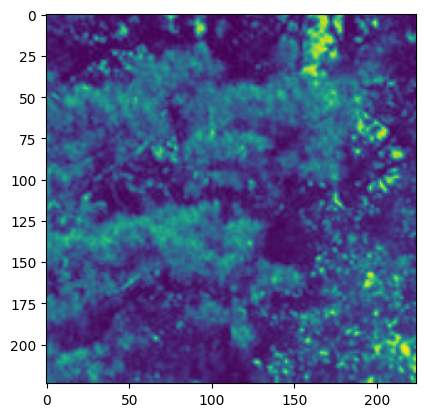

Actual label: Acer rubrum L.
Predicted label: Achillea millefolium L.


In [52]:
val_img, val_label = next(iter(val_dataloader))

test_predictor(trained_model= trained_model, val_img = val_img, val_label = val_label, decoded_labels = full_dataset.decoded_labels)